In [1]:
#!pip uninstall albumentations
#!pip install albumentations==0.5.2
!pip install vit-pytorch
!pip install timm

In [2]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from PIL import Image
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from vit_pytorch import ViT
import albumentations
import albumentations.pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, transforms
from matplotlib import pyplot as plt
import cv2
import numpy as np
import copy
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import timm
from scipy.special import softmax

In [35]:
PATH = "/home/dona/bm75/Project_Chathurika/Classification/data/data/"
SEGMENT = "body"
CLASSIFIER = 'vit'
path_for_models = PATH + 'models/'
path_to_save_values = PATH + 'remove_background/results/'

In [36]:
torch.cuda.empty_cache()

In [37]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [38]:
# processing dataset metadata
def process_dataset_meta_info(path, part):
    true_files = []
    true_file_paths = os.listdir(path + 'WFT_' + part + '/' )
    true_file_paths.sort()
    for item in true_file_paths:
        if item[-4:] == ".png" or item[-4:] == ".jpg":
            true_files.append(path + 'WFT_' + part + '/'  + item)
    true_labels = [1]*len(true_files)

    negative_files = []
    negative_file_paths = os.listdir(path + 'NOTWFT_' + part + '/' )
    negative_file_paths.sort()
    for item in negative_file_paths:
        if item[-4:] == ".png" or item[-4:] == ".jpg":
            negative_files.append(path + 'NOTWFT_' + part + '/' + item)
    negative_labels = [0]*len(negative_files)

    return true_files + negative_files, true_labels + negative_labels

file_paths, labels = process_dataset_meta_info(PATH + 'remove_background/', SEGMENT)
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(np.array(file_paths), np.array(labels), random_state= 0, test_size = 0.2, shuffle = True, stratify = labels)
print(len(train_file_paths))
print(len(test_file_paths))

340
85


In [39]:
# reading thrip dataset
class ThripDataset(Dataset):
    def __init__(self, file_paths, labels, is_train, required_transform=None, optional_transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.required_transform = required_transform
        self.optional_transform = optional_transform
        self.is_train = is_train

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx] # extract the label
        file_path = self.file_paths[idx] # extract the filepath
        #image = Image.open(file_path) # read the image with PIL
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.optional_transform and self.is_train:
            image = self.optional_transform(image=image)['image']

        if self.required_transform:
            image = self.required_transform(image)
        
        data_sample = {'x': image, 'y': label}
        return data_sample

In [40]:
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average = "macro")
    mat = confusion_matrix(y_true, y_pred)

    print("accuracy:", acc)
    print("precision:", p)
    print("recall:", r)
    print("f-score:", f)
    print("confusion matrix:")
    print(mat, '\n')

In [41]:
# defining data augmentation and transforms
optional_transforms = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.VerticalFlip(), 
])

required_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [42]:
train_dataset = ThripDataset(file_paths=train_file_paths, labels=train_labels, is_train = True, optional_transform = optional_transforms, required_transform = required_transforms)
test_dataset = ThripDataset(file_paths=test_file_paths, labels=test_labels, is_train = False, optional_transform = optional_transforms, required_transform = required_transforms)

batch_size = train_dataset.__len__()
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size) # len(test_dataset))
dataloaders = {'train': train_dataloader, 'test': test_dataloader}
dataset_size = {'train': len(train_dataset), 'test': len(test_dataset)}
class_names = ['NOTWFT', 'WFT']

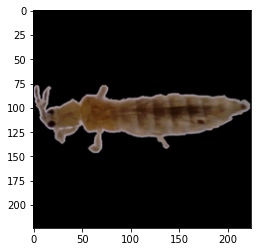

In [43]:
for idx, data in enumerate(test_dataloader):
    #print(data)
    data = data['x'].detach().cpu().numpy()
    im = np.moveaxis(data[0], 0, -1)
    plt.imshow(im)
    break

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_train_acc = 0.0
    best_loss = 1000000
    loss_vals= defaultdict(lambda: [])
    acc_vals= defaultdict(lambda: [])
    count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs = data['x'].to(device)
                labels = data['y'].to(device).long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print(loss.item(), preds, labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            loss_vals[phase].append(epoch_loss)
            acc_vals[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'test' and count == 0: #epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == "train":
                if best_train_acc < epoch_acc:
                    best_train_acc = epoch_acc
                    best_loss = epoch_loss
                    print(".........update ...", epoch)
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_model = copy.deepcopy(model)
                    count = 0
                else:
                    count += 1
                    
        if count == 20:
            break
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))
    #print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    for data in dataloaders["test"]:
        inputs = data['x'].to(device)
        labels = data['y'].to(device).long()
        outputs = best_model(inputs)
        
    for data in dataloaders["train"]:
        inputs_tr = data['x'].to(device)
        labels_tr = data['y'].to(device).long()
        outputs_tr = best_model(inputs_tr)
        
    return best_model, outputs, labels, outputs_tr, labels_tr, loss_vals, acc_vals

In [46]:
timm.list_models('*vit*')

['convit_base',
 'convit_small',
 'convit_tiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_384',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_224_in21k',
 'vit_sma

In [51]:
model_ft = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model_ft = model_ft.to(device)

In [52]:
for param in model_ft.parameters():
    param.requires_grad = False
    
for param in model_ft.blocks[11].parameters():
    param.requires_grad = False

for param in model_ft.head.parameters():
    param.requires_grad = True

In [53]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum = 0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)

In [54]:
model, outputs, labels, outputs_tr, labels_tr, loss_vals, acc_vals = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 1.3104 Acc: 0.5059
.........update ... 0
test Loss: 234.1485 Acc: 0.4941
Epoch 1/99
----------
train Loss: 237.0528 Acc: 0.4941
test Loss: 120.8404 Acc: 0.4941
Epoch 2/99
----------
train Loss: 123.1254 Acc: 0.4941
test Loss: 263.0249 Acc: 0.5059
Epoch 3/99
----------
train Loss: 261.1471 Acc: 0.5059
test Loss: 319.7133 Acc: 0.5059
Epoch 4/99
----------
train Loss: 315.6737 Acc: 0.5059
test Loss: 70.3484 Acc: 0.5294
Epoch 5/99
----------
train Loss: 70.8119 Acc: 0.5588
.........update ... 5
test Loss: 330.6427 Acc: 0.4941
Epoch 6/99
----------
train Loss: 335.0202 Acc: 0.4941
test Loss: 443.5143 Acc: 0.4941
Epoch 7/99
----------
train Loss: 449.4976 Acc: 0.4941
test Loss: 421.2159 Acc: 0.4941
Epoch 8/99
----------
train Loss: 426.7646 Acc: 0.4941
test Loss: 368.6312 Acc: 0.4941
Epoch 9/99
----------
train Loss: 371.5843 Acc: 0.4941
test Loss: 288.8561 Acc: 0.4941
Epoch 10/99
----------
train Loss: 291.3395 Acc: 0.4941
test Loss: 184.5663 Acc: 0.4941
Ep

In [19]:
print(len(loss_vals['train']))

38


In [20]:
def save_values_to_files(file, description, list1, list2 = None):
    f=open(file, "a+")
    f.write(description + '\n')
    
    if list2 == None:
        for d1 in list1:
            if not isinstance(d1, str):
                pass
                d1 = d1.detach().cpu().numpy()
            f.write(str(d1) + '\n')
    
    if list2 != None:
        for d1, d2 in zip(list1, list2):
                d1 = d1.detach().cpu().numpy()  
                if not isinstance(d2, int):
                    d2 = d2.detach().cpu().numpy()
                f.write(str(d1) + ', ' + str(d2) + '\n')
            
    f.close()

In [21]:
def save_acc_loss_to_files(file, description, list1, list2):
    f=open(file, "a+")
    f.write(description + '\n')
    count = 0
    for (d1, d2 , d3, d4) in zip(list1['train'], list2['train'], list1['test'], list2['test']):
        d2 = d2.detach().cpu().numpy()
        d4 = d4.detach().cpu().numpy()
        f.write(str(count) + ', ' + str(d1) + ', ' + str(d2) + ', ' + str(d3) + ', ' + str(d4)+ '\n')
        count = count + 1
            
    f.close()

In [22]:
save_values_to_files(path_to_save_values + SEGMENT + '_test.txt', 'test_outputs, labels', outputs, labels)
save_values_to_files(path_to_save_values + SEGMENT + '_train.txt', 'train_outputs, labels', outputs_tr, labels_tr)

In [23]:
save_acc_loss_to_files(path_to_save_values + SEGMENT  + '_loss_and_acc.txt', 'ephoc, train_loss, train_acc, test_loss, test_acc', loss_vals, acc_vals)

In [24]:
torch.save(model.state_dict(), path_for_models + SEGMENT + "_vit_base_patch16_224")

In [25]:
model.load_state_dict(torch.load(path_for_models + SEGMENT + "_vit_base_patch16_224"))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [26]:
def read_data(path, filename):
    #PATH  = "/home/dona/bm75/Project_Chathurika/Classification/data/results/"
    f = open(path + filename, 'r')
    f.readline()
    
    predictions = []
    labels = []
    for line in f:
        print(line)
        splits = line.strip().split(']')
        #print(splits[-1])
        labels.append(int(splits[-1].split(',')[-1]))
        if len(splits[0].split()) > 2:
            preds = [float(splits[0].split()[1]), float(splits[0].split()[-1])] 
        else:
            preds = [float(splits[0].split()[0].split('[')[-1]), float(splits[0].split()[-1])]
        #print(preds, softmax(np.array(preds))[1])
        predictions.append(softmax(np.array(preds))[1])
    # print("=============================")
    return labels, predictions

In [28]:
filenames = ['thorax'] #, 'abdomen', 'thorax', 'head']
#filenames = ['body_resnet_101']
train_labels_list = []
test_labels_list = []
train_predictions_list = []
test_predictions_list = []
for filename in filenames:
#     labels, predictions = read_data(path_to_save_values, filename + '_train.txt')
#     predictions = np.array(predictions).reshape(-1,1)
#     train_labels_list.append(labels)
#     train_predictions_list.append(predictions)
    
    labels, predictions = read_data(path_to_save_values, filename + '_test.txt')
    predictions = np.array(predictions).reshape(-1,1)

    print(filename)
    predicted_labels = predictions.copy()
    predicted_labels[predicted_labels>0.5]=1
    predicted_labels[predicted_labels<=0.5]=0
    print(accuracy_score(labels, predicted_labels))
    p, r, f, _ = precision_recall_fscore_support(labels, predicted_labels, average="binary")
    print(p, r, f)
    test_labels_list.append(labels)
    test_predictions_list.append(predictions)

[-4.696905   3.7760048], 1

[ 1.2462081 -0.9109515], 0

[ 1.4552462 -3.046984 ], 1

[-7.7675295  7.661752 ], 1

[-7.7802935  9.065945 ], 1

[ 5.432519 -5.669474], 0

[-6.640392  6.816803], 1

[-6.5087204  3.399523 ], 1

[ 6.388374  -6.4553413], 0

[-9.110363  7.550493], 1

[ 4.1733427 -5.148552 ], 0

[ 2.307739  -1.3853528], 0

[ 7.3950057 -9.38774  ], 0

[ 5.884893  -4.5724006], 0

[ 3.3829484 -3.9205523], 1

[-1.9281546  3.058675 ], 1

[-6.0635657  4.364213 ], 1

[-3.0635657  4.48643  ], 1

[ 4.1023183 -2.5074985], 1

[ 0.6985105 -1.1120402], 0

[ 6.7122755 -8.4271755], 0

[-12.442335  10.061161], 1

[-4.7936563  5.8208485], 1

[-2.2014618  1.7875137], 0

[ 3.5763001 -2.7442935], 0

[-10.59102    8.906187], 1

[-3.6645489  4.358213 ], 1

[ 8.120406 -8.628601], 0

[ 4.0268474 -2.8394835], 0

[ 7.095675 -7.092759], 0

[-1.6443132  0.266495 ], 0

[-4.30736    3.7380934], 1

[-9.212468  9.551464], 1

[ 4.477267  -5.3679795], 0

[ 4.316609  -3.8168705], 0

[ 6.9052057 -6.8285003], 0

[-7.